<a href="https://colab.research.google.com/github/baronrogers5/person-classifier/blob/master/Person_using_DenseNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Imports

In [1]:
%tensorflow_version 1.x
%matplotlib inline

import cv2
import json

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from functools import partial
from pathlib import Path 
from tqdm import tqdm
from skimage import io
from pathlib import Path
import numpy as np

from google.colab.patches import cv2_imshow

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

import keras
from keras.layers.core import Dropout
from keras.layers.core import Flatten
from keras.layers.core import Dense
from keras.layers import Input
from keras.models import Model
from keras.optimizers import SGD, Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.densenet import DenseNet121
from keras.layers import GlobalAveragePooling2D, BatchNormalization
from keras.utils import plot_model

import os
from keras.callbacks import LearningRateScheduler, ModelCheckpoint, ReduceLROnPlateau, EarlyStopping

Using TensorFlow backend.


## Fetch Data

The google drive link contains the person data

In [3]:
# mount gdrive and unzip data
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
!unzip -q "/content/gdrive/My Drive/hvc_data.zip"
# look for `hvc_annotations.csv` file and `resized` dir
%ls 

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive
gdrive/  hvc_annotations.csv  resized/  sample_data/


### Read the annotations file 

We will be using [pandas](https://pandas.pydata.org/) for reading the input dataframe, and creating one-hot encoded dummy columns.

In [3]:
df = pd.read_csv('hvc_annotations.csv'); df.head()

,filename,gender,imagequality,age,weight,carryingbag,footwear,emotion,bodypose,image_path
0,images/Set1/5580_2 (3).jpg,male,Average,35-45,normal-healthy,Grocery/Home/Plastic Bag,Normal,Neutral,Front-Frontish,resized/1.jpg
1,images/Set1/4650_1 (4).jpg,female,Average,35-45,over-weight,None,Normal,Angry/Serious,Front-Frontish,resized/2.jpg
2,images/Set1/44880_0.jpg,male,Good,45-55,normal-healthy,Grocery/Home/Plastic Bag,CantSee,Neutral,Front-Frontish,resized/3.jpg
3,images/Set1/26130_2.jpg,male,Good,45-55,normal-healthy,Daily/Office/Work Bag,Normal,Neutral,Front-Frontish,resized/4.jpg
4,images/Set1/IMG (4438).jpg,female,Good,35-45,slightly-overweight,None,CantSee,Neutral,Front-Frontish,resized/5.jpg


delete the filename column, as it was used for data collection, and does not serve a purpose now. 


In [0]:
del df['filename']

### Data PreProcessing

Neural networks expect the prediction labels to be one-hot encoded.
So that the predicted probabilities [equal to the number of classes] can be directly matched against the correct labels.

Hence, we need to convert all our prediction labels to one-hot encoded with a prefix, so that it becomes easier to identify them.

In [5]:
one_hot_df = pd.concat([
    df[["image_path"]],
    pd.get_dummies(df.gender, prefix="gender"),
    pd.get_dummies(df.imagequality, prefix="imagequality"),
    pd.get_dummies(df.age, prefix="age"),
    pd.get_dummies(df.weight, prefix="weight"),
    pd.get_dummies(df.carryingbag, prefix="carryingbag"),
    pd.get_dummies(df.footwear, prefix="footwear"),
    pd.get_dummies(df.emotion, prefix="emotion"),
    pd.get_dummies(df.bodypose, prefix="bodypose"),
], axis = 1)

df.shape

(13573, 9)

In [9]:
one_hot_df.head().T

,0,1,2,3,4
image_path,resized/1.jpg,resized/2.jpg,resized/3.jpg,resized/4.jpg,resized/5.jpg
gender_female,0,1,0,0,1
gender_male,1,0,1,1,0
imagequality_Average,1,1,0,0,0
imagequality_Bad,0,0,0,0,0
imagequality_Good,0,0,1,1,1
age_15-25,0,0,0,0,0
age_25-35,0,0,0,0,0
age_35-45,1,1,0,0,1
age_45-55,0,0,1,1,0


calculate the mean and stddev for normalization

In [0]:
images = np.array([cv2.resize(io.imread(p), (200, 200)) for p in df.iloc[:, -1]])
mean = []
std = []
for i in range(images.shape[-1]):
    pixels = images[:, :, :, i].ravel()
    mean.append(np.mean(pixels))
    std.append(np.std(pixels))

In [0]:
mean, std

([46.56585295255286, 41.46895223605688, 41.246545649451114],
 [69.21208428987939, 63.936488294726296, 63.29494237674264])

Let's look at the one-hot encoded columns

Label columns per attribute

In [0]:
_gender_cols_ = [col for col in one_hot_df.columns if col.startswith("gender")]
_imagequality_cols_ = [col for col in one_hot_df.columns if col.startswith("imagequality")]
_age_cols_ = [col for col in one_hot_df.columns if col.startswith("age")]
_weight_cols_ = [col for col in one_hot_df.columns if col.startswith("weight")]
_carryingbag_cols_ = [col for col in one_hot_df.columns if col.startswith("carryingbag")]
_footwear_cols_ = [col for col in one_hot_df.columns if col.startswith("footwear")]
_emotion_cols_ = [col for col in one_hot_df.columns if col.startswith("emotion")]
_bodypose_cols_ = [col for col in one_hot_df.columns if col.startswith("bodypose")]

The original size of the images were 200x200, and they were resized while sharing the dataset, because the default training and inference were done against vgg16, which requires a (224x224) input. 

Since, we will be using a [densenet](https://towardsdatascience.com/review-densenet-image-classification-b6631a8ef803) as our architecture. We don't need the extra computation and hence we resize the images to (200x200).

Let's create the keras Sequence which can be called to give a sequence of batches when called by fit_generator

In [0]:
class PersonDataGenerator(keras.utils.Sequence):
    """Ground truth data generator"""

    def __init__(self, df, batch_size=32, image_size=200, shuffle=True, augmentation=None):
        self.df = df
        self.batch_size=batch_size
        self.shuffle = shuffle
        self.augmentation = augmentation
        self.image_size = image_size
        self.normalize_image = lambda x: (x - mean) / std
        self.on_epoch_end()
        

    def __len__(self):
        return int(np.floor(self.df.shape[0] / self.batch_size))

    def __getitem__(self, index):
        """fetch batched images and targets"""
        batch_slice = slice(index * self.batch_size, (index + 1) * self.batch_size)
        items = self.df.iloc[batch_slice]
        
        # resizing the image to (self.image_size, self.image_size)
        image = np.stack([self.normalize_image(cv2.resize(cv2.imread(item["image_path"]), 
                                            (self.image_size, self.image_size))) for _, item in items.iterrows()])

        if self.augmentation is not None:
            # This is required for featurewise-center and featurewise-stdnorm
            # self.augmentation.fit(image)
            image = self.augmentation.flow(image, shuffle=False).next()

        target = {
            "gender_output": items[_gender_cols_].values,
            "image_quality_output": items[_imagequality_cols_].values,
            "age_output": items[_age_cols_].values,
            "weight_output": items[_weight_cols_].values,
            "bag_output": items[_carryingbag_cols_].values,
            "pose_output": items[_bodypose_cols_].values,
            "footwear_output": items[_footwear_cols_].values,
            "emotion_output": items[_emotion_cols_].values,
        }
        return image, target

    def on_epoch_end(self):
        """Updates indexes after each epoch"""
        if self.shuffle == True:
            self.df = self.df.sample(frac=1).reset_index(drop=True)

### Creating the train and validation data

It is important to set a random seed if we are going to be calling fit_generator multiple times, it would prevent train and val data mixing. 

In [0]:
np.random.seed(42)
from sklearn.model_selection import train_test_split
train_df, val_df = train_test_split(one_hot_df, test_size=0.15, random_state=42)
train_df.shape, val_df.shape

In [0]:
def get_random_eraser(p=0.5, s_l=0.02, s_h=0.4, r_1=0.3, r_2=1/0.3, v_l=0, v_h=255, pixel_level=False):
    def eraser(input_img):
        img_h, img_w, img_c = input_img.shape
        p_1 = np.random.rand()

        if p_1 > p:
            return input_img

        while True:
            s = np.random.uniform(s_l, s_h) * img_h * img_w
            r = np.random.uniform(r_1, r_2)
            w = int(np.sqrt(s / r))
            h = int(np.sqrt(s * r))
            left = np.random.randint(0, img_w)
            top = np.random.randint(0, img_h)

            if left + w <= img_w and top + h <= img_h:
                break

        if pixel_level:
            c = np.random.uniform(v_l, v_h, (h, w, img_c))
        else:
            c = np.random.uniform(v_l, v_h)

        input_img[top:top + h, left:left + w, :] = c

        return input_img

    return eraser

Let's create insatnces of train and val generators.
The train_gen, can be called with get_random_eraser (cutout) as a pre-processing function. 

In [0]:
# create train and validation data generators
train_gen = PersonDataGenerator(train_df, batch_size=32, image_size=200, augmentation=ImageDataGenerator(
    width_shift_range=0.2,
    height_shift_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    preprocessing_function=get_random_eraser(v_h=1, s_l=0.01, s_h=0.2, r_1=0.1, r_2=1)
))

valid_gen = PersonDataGenerator(val_df, batch_size=32, image_size=200, shuffle=False)

In [0]:
# get number of output units from data
images, targets = next(iter(train_gen))
# num_units actually tells the number of one-hot encoded values / choices for a category
num_units = { k.split("_output")[0]:v.shape[1] for k, v in targets.items()}
num_units

{'age': 5,
 'bag': 3,
 'emotion': 4,
 'footwear': 3,
 'gender': 2,
 'image_quality': 3,
 'pose': 3,
 'weight': 4}

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



Train Data Shape: (200, 200, 3), Validation Data Shape: (200, 200, 3)


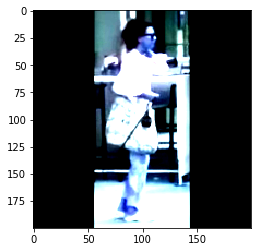

In [0]:
# This can act as the measure that val data is always the same
val_images, _ = next(iter(valid_gen))
plt.imshow(val_images[1]);
print()
print(f'Train Data Shape: {images[0].shape}, Validation Data Shape: {val_images[0].shape}')

# Designing the architecture

We are not using pre-trained weights and starting from scratch as that was one of the requirements of this exercise.
<br>We take a densenet backbone, without the head.

Since this is a multi-task classification. The final model we are going for would be something like this:


```
inputs -> 
        densenet121 + GAP -> (
                            tower + gender_head,
                            tower + age_head,
                            tower + emotion_head, ...
                                                    ) -> outputs 

```
1. Choose an architecture as a backbone (here we are choosing densenet121, as it worked better than resnet50 in intial tests), do not include the head, as we would build our own.
2. Build towers for each class, the architecture of the towers would largely remain the same.
3. Build the respective heads which are the outputs for each class.
4. Construct the overall model, specifying the inputs and the outputs.  

#### Constructing the backbone

In [0]:
backbone = DenseNet121(
    include_top=False,
    input_shape=(200, 200, 3),
    weights= None
)

model = Model(inputs=backbone.input, outputs=backbone.output)

![backbone head](https://raw.githubusercontent.com/baronrogers5/person-classifier/master/images/backbone_head.png)

The final shape after relu is (6, 6, 1024). 

This is passed through GlobalAveragePooling (further referenced as GAP) to average each feature map across the channel dimension. This brings the tensor shape to a flat (None, 1024).

 I strongly believe this can be improved if instead of only using GAP, we also use GlobalMaxPooling and concatenate the outputs. That results in 2048 rank 1 tensor, which would have advantages of both mean and max results.

#### Building the tower

The tower adds a batchnorm after GAP, to normalize the results after GAP and also a small amount of dropout, to improve resilience.<br> It is followed by a densely connected layer that reduces the nodes to 128, on which each head builds.

In [0]:
def build_tower(in_layer):
    neck = BatchNormalization()(in_layer)
    neck = Dropout(0.1)(neck)
    neck = Dense(128, activation='relu')(neck)
    return neck

The head is the final layer that produces outputs.<br> Let's take pose, there can be 3 possible outputs for it, namely **(front-frontish, back and side)**, so each possible output needs a final node which represents the probability of it's occurrence.<br> `num_units` contains the mapping of each name and the number of categories present. `build_head` builds the heads of each categroy assigning appropriate final nodes as per `num_units`.  

```
{
    'age': 5,
    'bag': 3,
    'emotion': 4,
    'footwear': 3,
    'gender': 2,
    'image_quality': 3,
    'pose': 3,
    'weight': 4
 }
 ```

In [0]:
def build_head(name, in_layer):
    return Dense(num_units[name], activation='softmax', name=f'{name}_output')(in_layer)

## Code to build the complete Model

In [0]:
backbone = DenseNet121(
    include_top=False,
    input_shape=(200, 200, 3),
    weights=None,                     # No pre-trained weights, for imagenet weights, pass `imagenet` as arg. 
)

# 
neck = GlobalAveragePooling2D()(backbone.output)

def build_tower(in_layer):
    neck = BatchNormalization()(in_layer)
    neck = Dropout(0.1)(neck)
    neck = Dense(128, activation='relu')(neck)
    return neck

def build_head(name, in_layer):
    return Dense(num_units[name], activation='softmax', name=f'{name}_output')(in_layer)

#heads
gender = build_head("gender", build_tower(neck))
image_quality = build_head("image_quality", build_tower(neck))
age = build_head("age", build_tower(neck))
weight = build_head("weight", build_tower(neck))
bag = build_head("bag", build_tower(neck))
footwear = build_head("footwear", build_tower(neck))
emotion = build_head("emotion", build_tower(neck))
pose = build_head("pose", build_tower(neck))


model = Model(
    inputs=backbone.input,
    outputs=[gender, image_quality, age, weight, bag, footwear, pose, emotion]
)

In [0]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 200, 200, 3)  0                                            
__________________________________________________________________________________________________
zero_padding2d_1 (ZeroPadding2D (None, 206, 206, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 100, 100, 64) 9408        zero_padding2d_1[0][0]           
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 100, 100, 64) 256         conv1/conv[0][0]                 
____________________________________________________________________________________________

In [0]:
# TODO: Attach an image of head
plot_model(model)

Let's create a function to check whether all the layers are trainable 

In [0]:
def check_all_layers_trainable(model):
    # skip the input layer
    for l in model.layers[1:]:
        assert l.trainable == True, "Complete Model is not trainable"

In [0]:
check_all_layers_trainable(model)

### Training Callbacks

1. <u>`ReduceLROnPlateau`</u> -> To reduce learning_rate when the model val_loss does not improve by `min_delta` for some `patience` epochs
2. <u>`ModelCheckpoint`</u> -> To save the model weights, in specified directory.
3. <u>`EarlyStopping`</u> -> To stop training if `val_loss` does not improve by `min_delta` for `patience` epochs, restore the `best_weights` during training after stopping. 

In [0]:
# reduce lr on plateau
reduce_lr_on_plateau = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.7,
    patience=3,
    min_lr=1e-6,
    verbose=1,
    min_delta=1e-3
)

# save the model
save_dir = os.path.join(os.getcwd(), 'gdrive/My Drive/Person_MultiClass')
model_name = 'person_multiclass_model_densenet_200_normalized_frozen_reduce_dropout.h5'

if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
filepath = os.path.join(save_dir, model_name)

# checkpoint callback
checkpoint = ModelCheckpoint(filepath=filepath,
                             monitor='val_loss',
                             verbose=1,
                             save_best_only=True)

# Early Stopping
early_stopping = EarlyStopping(
    patience=8,
    verbose=1,
    min_delta=1e-3,
    restore_best_weights=True
)


### Compile the model

The model compilation step has been implemented as a function, so that it can be called from any cell, and on any model (backbone or partial models) 

In [0]:
def compile_model(model):
    model.compile(
        optimizer=Adam(lr=9e-4),
        loss = 'categorical_crossentropy',
        metrics=['accuracy']
    )

### Functions for common use cases 

In [0]:
def freeze_model(model: keras.Model):
    for l in model.layers:
        l.trainable = False

def unfreeze_model(model: keras.Model):
    for l in model.layers:
        l.trainable = True

def print_layer_name_and_trainability(model: keras.Model):
    for l in model.layers:
        print(l.name, l.trainable)

In [0]:
def show_results(model: keras.Model, show_loss=False):
    data = []
    results = model.evaluate_generator(valid_gen, verbose=1)
    for m, r in zip(model.metrics_names, results):
        if show_loss:
            data.append({'metric_name': m, 'accuracy': r})            
        
        elif 'acc' in m:
                data.append({'metric_name': m, 'accuracy': r})
    
    df = pd.DataFrame(data, columns=['metric_name', 'accuracy'])
    print(df)

### Let the training begin

Initial rounds of training were done with a smaller image size of (100x100), so that the model gets to adjust it's initial weights. <br> This helps when data of size (200x200) is introduced, as it acts as completely new data for the model. And, we can do the fine-tuned training with the larger images.

In [0]:
compile_model(model)

# for 50 epochs train on (100, 100, 3), with adam defaults, reduce_lr and no data augmentation
model.fit_generator(
    generator=train_gen,
    validation_data=valid_gen,
    use_multiprocessing=True,
    workers=6, 
    epochs=50,
    verbose=1,
    callbacks=[reduce_lr_on_plateau, checkpoint, early_stopping]
)

Epoch 1/50
360/360 [==============================] - 137s 380ms/step - loss: 7.2925 - gender_output_loss: 0.5713 - image_quality_output_loss: 0.9710 - age_output_loss: 1.3900 - weight_output_loss: 0.9666 - bag_output_loss: 0.8790 - footwear_output_loss: 0.8579 - pose_output_loss: 0.7673 - emotion_output_loss: 0.8894 - gender_output_acc: 0.7066 - image_quality_output_acc: 0.5486 - age_output_acc: 0.3987 - weight_output_acc: 0.6335 - bag_output_acc: 0.5918 - footwear_output_acc: 0.6095 - pose_output_acc: 0.6721 - emotion_output_acc: 0.7128 - val_loss: 7.2960 - val_gender_output_loss: 0.5658 - val_image_quality_output_loss: 0.9623 - val_age_output_loss: 1.4039 - val_weight_output_loss: 0.9596 - val_bag_output_loss: 0.8713 - val_footwear_output_loss: 0.8495 - val_pose_output_loss: 0.7811 - val_emotion_output_loss: 0.9026 - val_gender_output_acc: 0.7072 - val_image_quality_output_acc: 0.5645 - val_age_output_acc: 0.3876 - val_weight_output_acc: 0.6447 - val_bag_output_acc: 0.5953 - val_foo

Save the trained model as  - `person_multiclass_model_densenet_100_v1.h5`.<br>
Now let's freeze the initial layers(backbone), and train a bit further.


In [0]:
for l in model.layers[:427]:
    l.trainable = False 

for i, l in enumerate(model.layers):
    print(i, l, l.trainable)

In [0]:
compile_model(model)

# for 50 epochs train on (100, 100, 3), with adam defaults, reduce_lr and no data augmentation and frozen initial layers
model.fit_generator(
    generator=train_gen,
    validation_data=valid_gen,
    use_multiprocessing=True,
    workers=6, 
    epochs=50,
    verbose=1,
    callbacks=[reduce_lr_on_plateau, checkpoint, early_stopping]
)

Epoch 1/50
360/360 [==============================] - 58s 162ms/step - loss: 6.5428 - gender_output_loss: 0.3617 - image_quality_output_loss: 0.9443 - age_output_loss: 1.3462 - weight_output_loss: 0.9398 - bag_output_loss: 0.8157 - footwear_output_loss: 0.7407 - pose_output_loss: 0.5292 - emotion_output_loss: 0.8653 - gender_output_acc: 0.8460 - image_quality_output_acc: 0.5514 - age_output_acc: 0.4130 - weight_output_acc: 0.6369 - bag_output_acc: 0.6438 - footwear_output_acc: 0.6798 - pose_output_acc: 0.7866 - emotion_output_acc: 0.7101 - val_loss: 7.1298 - val_gender_output_loss: 0.5135 - val_image_quality_output_loss: 0.9556 - val_age_output_loss: 1.3717 - val_weight_output_loss: 0.9871 - val_bag_output_loss: 0.8501 - val_footwear_output_loss: 0.8493 - val_pose_output_loss: 0.6608 - val_emotion_output_loss: 0.9418 - val_gender_output_acc: 0.7807 - val_image_quality_output_acc: 0.5635 - val_age_output_acc: 0.3947 - val_weight_output_acc: 0.6346 - val_bag_output_acc: 0.6351 - val_foot

Saving the model as `person_multiclass_model_densenet_100_v1_frozen.h5`. <br> We've reached a val_loss of `7.06014`.

Now's the time to unfreeze everything and try with higher resolution images


In [0]:
for l in model.layers:
    l.trainable = True

check_all_layers_trainable(model)

In [0]:
model.load_weights('/content/gdrive/My Drive/Person_MultiClass/person_multiclass_model_densenet_100_v1_frozen.h5')

In [0]:
compile_model(model)

# for 50 epochs train on (200, 200, 3), with reduce_lr, early stopping, no data augmentation
model.fit_generator(
    generator=train_gen,
    validation_data=valid_gen,
    use_multiprocessing=True,
    workers=6, 
    epochs=50,
    verbose=1,
    callbacks=[reduce_lr_on_plateau, checkpoint, early_stopping]
)

Epoch 1/50
360/360 [==============================] - 254s 705ms/step - loss: 6.9499 - gender_output_loss: 0.4700 - image_quality_output_loss: 0.9283 - age_output_loss: 1.3754 - weight_output_loss: 0.9548 - bag_output_loss: 0.8539 - footwear_output_loss: 0.8093 - pose_output_loss: 0.6844 - emotion_output_loss: 0.8737 - gender_output_acc: 0.7766 - image_quality_output_acc: 0.5577 - age_output_acc: 0.4029 - weight_output_acc: 0.6339 - bag_output_acc: 0.6071 - footwear_output_acc: 0.6390 - pose_output_acc: 0.7097 - emotion_output_acc: 0.7124 - val_loss: 6.9345 - val_gender_output_loss: 0.4449 - val_image_quality_output_loss: 0.9275 - val_age_output_loss: 1.3793 - val_weight_output_loss: 0.9659 - val_bag_output_loss: 0.8438 - val_footwear_output_loss: 0.8206 - val_pose_output_loss: 0.6353 - val_emotion_output_loss: 0.9172 - val_gender_output_acc: 0.7918 - val_image_quality_output_acc: 0.5675 - val_age_output_acc: 0.3846 - val_weight_output_acc: 0.6260 - val_bag_output_acc: 0.6149 - val_foo

In [0]:
model.load_weights('/content/gdrive/My Drive/Person_MultiClass/person_multiclass_model_densenet_200.h5')

Let's perform proper normalization, up until now I was using the `ImageDataGenerator`, method's normalizations, but now I've changed to calculating the mean and stddev on the complete dataset and normalizing. 

In [0]:
compile_model(model)

# for 50 epochs train on (200, 200, 3), with reduce_lr, early stopping, no data augmentation
model.fit_generator(
    generator=train_gen,
    validation_data=valid_gen,
    use_multiprocessing=True,
    workers=6, 
    epochs=50,
    verbose=1,
    callbacks=[reduce_lr_on_plateau, checkpoint, early_stopping]
)

Epoch 1/50
360/360 [==============================] - 251s 698ms/step - loss: 5.7250 - gender_output_loss: 0.2240 - image_quality_output_loss: 0.8542 - age_output_loss: 1.2293 - weight_output_loss: 0.8311 - bag_output_loss: 0.6838 - footwear_output_loss: 0.7377 - pose_output_loss: 0.3392 - emotion_output_loss: 0.8257 - gender_output_acc: 0.9097 - image_quality_output_acc: 0.5927 - age_output_acc: 0.4563 - weight_output_acc: 0.6675 - bag_output_acc: 0.7204 - footwear_output_acc: 0.6730 - pose_output_acc: 0.8757 - emotion_output_acc: 0.7135 - val_loss: 6.1829 - val_gender_output_loss: 0.2453 - val_image_quality_output_loss: 0.9001 - val_age_output_loss: 1.2741 - val_weight_output_loss: 0.8948 - val_bag_output_loss: 0.7365 - val_footwear_output_loss: 0.8112 - val_pose_output_loss: 0.4364 - val_emotion_output_loss: 0.8846 - val_gender_output_acc: 0.8973 - val_image_quality_output_acc: 0.5724 - val_age_output_acc: 0.4266 - val_weight_output_acc: 0.6498 - val_bag_output_acc: 0.6900 - val_foo

In [0]:
model.load_weights('/content/gdrive/My Drive/Person_MultiClass/person_multiclass_model_densenet_200_normalized.h5')

In [0]:
for l in backbone.layers:
    l.trainable = False

try:
    check_all_layers_trainable(model)
except AssertionError:
    for l in model.layers:
        print(l.name, l.trainable)

In [0]:
compile_model(model)

model.fit_generator(
    generator=train_gen,
    validation_data=valid_gen,
    use_multiprocessing=True,
    workers=6, 
    epochs=50,
    verbose=1,
    callbacks=[reduce_lr_on_plateau, checkpoint, early_stopping]
)



Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch 1/50
360/360 [==============================] - 183s 509ms/step - loss: 5.5681 - gender_output_loss: 0.2059 - image_quality_output_loss: 0.8399 - age_output_loss: 1.1948 - weight_output_loss: 0.8057 - bag_output_loss: 0.6544 - footwear_output_loss: 0.7317 - pose_output_loss: 0.3136 - emotion_output_loss: 0.8219 - gender_output_acc: 0.9198 - image_quality_output_acc: 0.6022 - age_output_acc: 0.4741 - weight_output_acc: 0.6773 - bag_output_acc: 0.7322 - footwear_output_acc: 0.6786 - pose_output_acc: 0.8862 - emotion_output_acc: 0.7144 - val_loss: 6.1222 - val_gender_output_loss: 0.2614 - val_image_quality_output_loss: 0.8823 - val_age_output_loss: 1.2627 - val_weight_output_loss: 0.8957 - val_bag_output_loss: 0.7391 - val_footwear_output_loss: 0.7876 - val_pose_output_loss: 0.4222 - val_emotion_output_loss: 0.8713 - val_gender_output_acc: 0.8929 - val_image_quality_output_acc: 0.5952 -

Some common methods, for doing the regular stuff again and again.

In [0]:
show_results(model)

63/63 [==============================] - 14s 228ms/step
                metric_name  accuracy
0         gender_output_acc  0.892857
1  image_quality_output_acc  0.595238
2            age_output_acc  0.443948
3         weight_output_acc  0.647817
4            bag_output_acc  0.702877
5       footwear_output_acc  0.656746
6           pose_output_acc  0.857639
7        emotion_output_acc  0.704365


In [0]:
model.load_weights('/content/gdrive/My Drive/Person_MultiClass/person_multiclass_model_densenet_200_normalized_frozen.h5')

In [0]:
compile_model(model)
model.load_weights('/content/gdrive/My Drive/Person_MultiClass/person_multiclass_model_densenet_200_normalized_frozen_augmented.h5')
show_results(model, show_loss=True)

63/63 [==============================] - 16s 249ms/step
                  metric_name  accuracy
0                        loss  6.113962
1          gender_output_loss  0.267376
2   image_quality_output_loss  0.883270
3             age_output_loss  1.261447
4          weight_output_loss  0.901494
5             bag_output_loss  0.746320
6        footwear_output_loss  0.760049
7            pose_output_loss  0.419371
8         emotion_output_loss  0.874636
9           gender_output_acc  0.888889
10   image_quality_output_acc  0.584821
11             age_output_acc  0.447421
12          weight_output_acc  0.652778
13             bag_output_acc  0.697917
14        footwear_output_acc  0.670635
15            pose_output_acc  0.857143
16         emotion_output_acc  0.704365
